## IMPORTING LIBRARIES

In [2]:
# local modules
# external libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# scikit-learn modelling algorithms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier    

# deployment libraries
import pickle as pc


import warnings
warnings.filterwarnings('ignore')

##### Function to load the dataset

In [3]:
def load_user_cookies_data(filename):
    if os.path.isfile(filename):
      return pd.read_csv(filename)
    else:
      return ("Invalid file name, make sure the filename is correct and is in the same package")

In [4]:
UserCookiesData = load_user_cookies_data("shopping.csv")

In [5]:
UserCookiesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
UserCookiesData.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [7]:
UserCookiesData['Revenue'] = UserCookiesData['Revenue'].astype(int)
UserCookiesData['Revenue'].value_counts()

0    10422
1     1908
Name: Revenue, dtype: int64

##### Helper functions for exploratory data analysis

In [8]:
def binary_to_ints(value):
    if value == True:
      return 1
    else:
      return 0

In [9]:
def train_validate_test_split(data, target, seed = 126):
    """
    It splits the data into train, validate and test sets.
    :return: three dataframes: train, validate, and test.
    """
    train_validate, test = train_test_split(data, test_size=0.20, random_state=seed, stratify=data[target])
    train, validate = train_test_split(train_validate, test_size=0.30, random_state=seed,stratify=train_validate[target])
    return train, validate, test


In [10]:
def process_unencoded_data(data):
    """
    It takes in a dataframe, drops duplicates, removes rows where tenure is 0, removes $ and , from
    TotalCharges, converts TotalCharges to float, strips whitespace from all object columns, and returns
    a train, validate, and test dataframe
    """
    data.drop_duplicates(inplace = True)
    categorical_columns = data.select_dtypes('object').columns

    for column in categorical_columns:
        data[column] = data[column].str.strip()
    return train_validate_test_split(data, 'Revenue')


univariate data exploratory analysis helper functions

In [11]:

def freq_table(train, cat_var):
    """
    It takes a dataframe and a categorical variable as input, and returns a frequency table as output
    :return: A dataframe with the unique values of the categorical variable, the count of each unique
    value, and the percentage of each unique value.
    """
    class_labels = list(train[cat_var].unique())
    freq_table = (
      pd.DataFrame(
        {cat_var: class_labels,
        'Count': train[cat_var].value_counts(normalize=False),
        'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)
        }))

    return freq_table




In [12]:
def univariate_quant(data,quantitative_variables):

    descriptive_statistics = data[quantitative_variables].describe()
    plt.figure(figsize=(8,2))
    plot = plt.subplot(1, 2, 1)
    plot = plt.hist(data[quantitative_variables], color='yellow')
    plot = plt.title(quantitative_variables)
    plot = plt.subplot(1, 2, 2)
    plot = plt.boxplot(data[quantitative_variables])
    plot = plt.title(quantitative_variables)
    return plot, descriptive_statistics


In [13]:
def univariate_categorical(data, categorical_vars):
    """
    It creates a bar chart of the frequency of each category in a categorical variable.
    :param data: the dataframe
    :param categorical_vars: The categorical variable you want to plot
    """
    frequency_table = freq_table(data, categorical_vars)
    plt.figure(figsize=(6,3))
    sns.barplot(x=categorical_vars, y='Count', data=frequency_table, color='lightblue')
    plt.xticks(rotation = 90)
    plt.title(categorical_vars)
    plt.show()
    print(frequency_table)

In [14]:
def univariate(data, categorical_vars, quantitative_vars):
    """
    This function takes in a dataframe, a list of categorical variables, and a list of quantitative
    variables. It then calls the univariate_categorical function for each categorical variable and the
    univariate_quant function for each quantitative variable.
    """
    for var in categorical_vars:
        univariate_categorical(data, var)

    for column in quantitative_vars:
        plot, descriptive_statistics = univariate_quant(data, column)
        plt.gca(figsize = 10)
        plt.show(plot)
        print(descriptive_statistics)

bivariate data analysis helper functions

In [15]:
def plot_cat_by_target(data, target_variable, categorical_var):
    """
    It takes a dataframe, a target variable, and a categorical variable, and plots the mean of the
    target variable for each category of the categorical variable
    :return: A plot
    """
    p = plt.figure(figsize=(10,2))
    p = sns.barplot(categorical_var, target_variable, data=data, alpha=.8, color='lightseagreen')
    overall_rate = data[target_variable].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p

In [16]:
def compare_means(data, target_variable, quantitative_vars, alt_hyp='two-sided'):
    x = data[data[target_variable]==0][quantitative_vars]
    y = data[data[target_variable]==1][quantitative_vars]
    return stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt_hyp)

In [17]:
def plot_boxen(data, target_variable, quantitative_var):
    """
    It plots a boxen plot for the quantitative variable and the target variable.
    """
    average = data[quantitative_var].mean()
    p = sns.boxenplot(data=data, x=target_variable, y=quantitative_var, color='orange')

    p = plt.title(quantitative_var)
    p = plt.axhline(average, ls='--', color='black')
    return p


In [18]:
def plot_swarm(data, target_variable, quantitative_var):
    """
    It plots a swarmplot of the quantitative variable against the target variable.
    """
    average = data[quantitative_var].mean()
    p = sns.swarmplot(data=data, x=target_variable, y=quantitative_var, color='lightgray')
    p = plt.title(quantitative_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

In [19]:
def bivariate_quant(data, target, quantitative_var):
    """
    It takes a dataframe, a target variable, and a quantitative variable, and then it prints the
    descriptive statistics for the quantitative variable, grouped by the target variable. It also plots
    a boxen plot of the quantitative variable, grouped by the target variable
    """
    print(quantitative_var, "\n____________________\n")
    descriptive_stats = data.groupby(target)[quantitative_var].describe()
    plt.figure(figsize=(4,4))
    plot_boxen(data, target, quantitative_var)
    # plot_swarm(data, target, quantitative_vars)
    plt.show()
    print(descriptive_stats, "\n")


In [20]:
def bivariate_categorical(data, target, categorical_variable):
    """
    It takes a dataframe, a target variable, and a categorical variable, and returns a crosstab of the
    two variables and a bar chart of the crosstab
    """
    ct = pd.crosstab(data[categorical_variable], data[target], margins=True)
    plot = plot_cat_by_target(data, target, categorical_variable)
    print("\nobserved:\n", ct)
    plt.show(plot)

In [63]:

def run_chi2(data, categorical_var, target_variable):
    """
    It takes in a dataframe, a categorical variable, and a target variable. It then runs a chi-squared
    test on the dataframe and returns the chi-squared summary, the observed values, and the expected
    values.
    """
    observed = pd.crosstab(data[categorical_var], data[target_variable])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p],
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

In [64]:

def plot_cat_by_target(data, target_variable, categorical_var):
    """
    It takes a dataframe, a target variable, and a categorical variable, and plots the mean of the
    target variable for each category of the categorical variable
    :return: A plot
    """
    p = plt.figure(figsize=(10,2))
    p = sns.barplot(categorical_var, target_variable, data=data, alpha=.8, color='lightseagreen')
    overall_rate = data[target_variable].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p



In [65]:

def two_t_test(data, quantitative_vars, target_variable):
    """
    The function takes in a dataframe, a list of quantitative variables, and a target variable. It then
    performs a Shapiro-Wilk test to check for normality, and if the p-value is less than 0.05, it
    performs a Mann-Whitney U test. If the p-value is greater than 0.05, it performs a Levene test to
    check for homogeneity of variance, and if the p-value is less than 0.05, it performs a Mann-Whitney
    U test.
    """
    columns = []
    p_values = []
    test_significance = []
    for var in quantitative_vars:
        columns.append(var)
        category_1 = data[var][data[target_variable] == False]
        category_2 = data[var][data[target_variable] == True]
        for bol in [category_1]:
            t_stats1, p_val1 = stats.shapiro(bol)
        for bin in [category_2]:
            t_stats2, p_val2 = stats.shapiro(bin)
        if p_val1 > 0.05 or p_val2 > 0.05:
            stats_3, p_val3 = stats.levene(category_1, category_2)

        if p_val1 <= 0.05 or p_val2 <= 0.05 or p_val3 <= 0.05:
            ms, mp = stats.mannwhitneyu(category_1, category_2)
            p_values.append(round(mp, 4))
        if mp < 0.05:
            test_significance.append('significant')
        else:
            test_significance.append('insignificant')

    return pd.DataFrame({'Feature': columns, 'P-Value': p_values, 'Significance': test_significance})

## EXPLORATORY DATA ANALYSIS

* Here We will use the helper functions in the local explore.py module

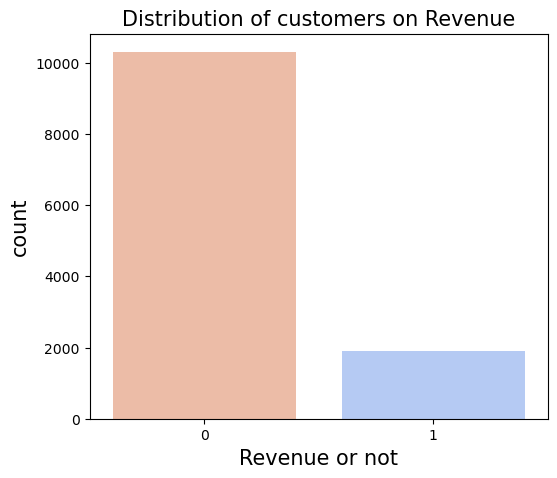

In [66]:
# checking the Distribution of customers on Revenue

plt.rcParams['figure.figsize'] = (13, 5)
plt.subplot(1, 2, 1)
sns.countplot(UserCookiesData['Revenue'], palette = 'coolwarm_r')
plt.title('Distribution of customers on Revenue', fontsize = 15)
plt.xlabel('Revenue or not', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.show()

##### Plotting a pie chart for operating systems distribution

In [67]:
UserCookiesData['OperatingSystems'].value_counts()

2    6541
1    2549
3    2530
4     478
8      75
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64

In [68]:
#Prepare and split into train, validate, and test sets.
train, validate, test = process_unencoded_data(data = UserCookiesData )


In [69]:
UserCookiesData.select_dtypes('object').columns

Index(['Month', 'VisitorType'], dtype='object')

In [70]:

categorical_vars = UserCookiesData.select_dtypes('object').columns
quantitative_vars = UserCookiesData.select_dtypes('float').columns
int_vars = UserCookiesData.select_dtypes('int').columns

##### Exploring univariate variables

In [71]:
UserCookiesData['OperatingSystems'].value_counts()

2    6541
1    2549
3    2530
4     478
8      75
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64

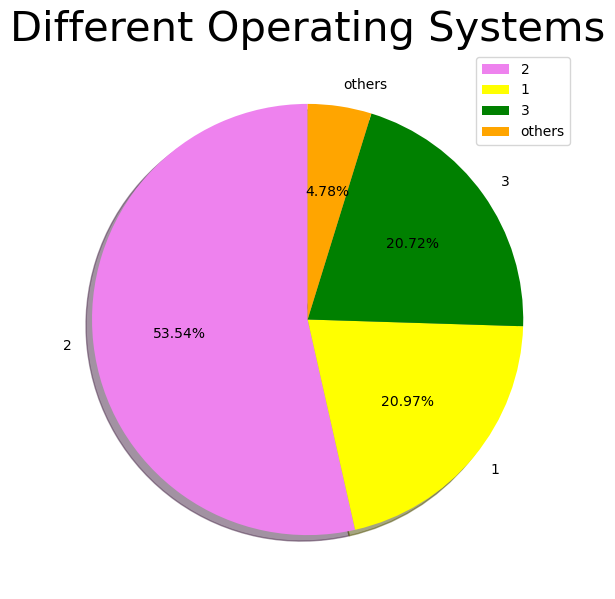

In [72]:
# This code cell is plotting a pie chart of the different operating systems.
size = [6601, 2585, 2555, 589]
colors = ['violet', 'yellow', 'green', 'orange']
labels = "2", "1", "3", "others"
plt.rcParams['figure.figsize'] = (18, 7)
plt.subplot(1, 2, 2)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%', startangle=90)
plt.title('Different Operating Systems', fontsize = 30)
plt.axis('off')
plt.legend()
plt.show()

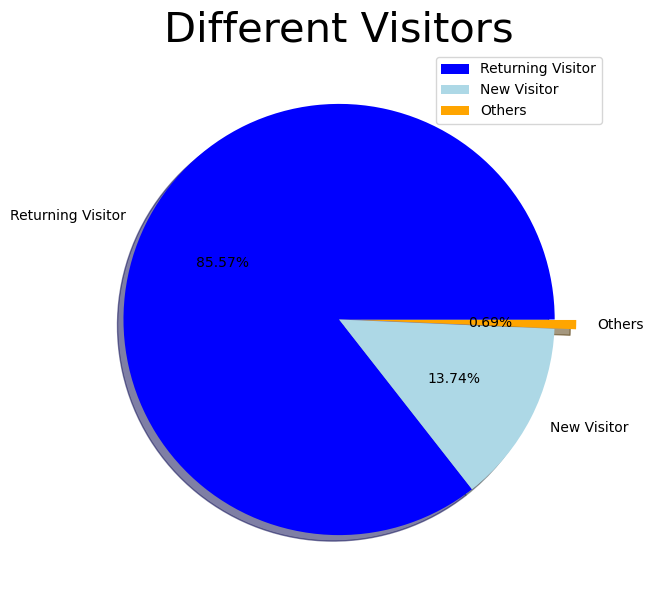

In [73]:
# This code cell is plotting a pie chart for the visitor types
size = [10551, 1694, 85]
explode = [0, 0, 0.1]
labels = "Returning Visitor", "New Visitor", "Others"
colors = ['blue', 'lightblue', 'orange']
plt.rcParams['figure.figsize'] = (18, 7)
plt.subplot(1, 2, 1)
plt.pie(size, colors = colors, labels = labels, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Different Visitors', fontsize = 30)
plt.axis('off')
plt.legend()
plt.show()

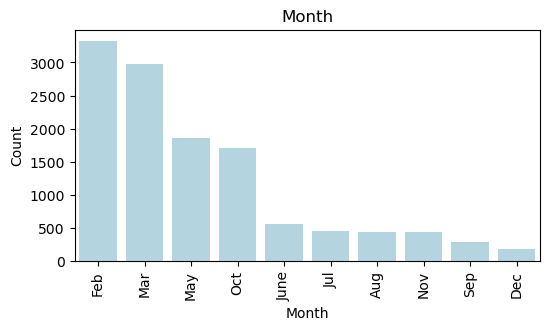

     Month  Count  Percent
May    Feb   3329    27.28
Nov    Mar   2982    24.43
Mar    May   1860    15.24
Dec    Oct   1706    13.98
Oct   June    549     4.50
Sep    Jul    448     3.67
Aug    Aug    433     3.55
Jul    Nov    432     3.54
June   Sep    285     2.34
Feb    Dec    181     1.48


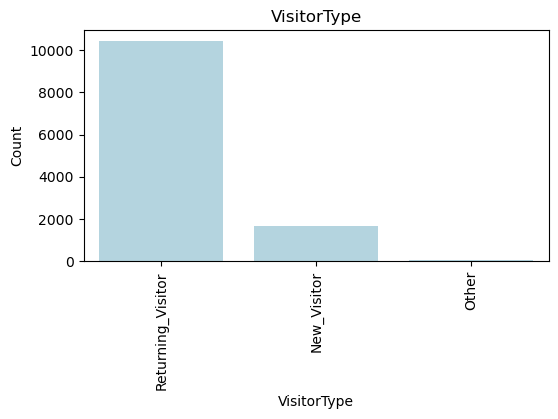

                         VisitorType  Count  Percent
Returning_Visitor  Returning_Visitor  10431    85.46
New_Visitor              New_Visitor   1693    13.87
Other                          Other     81     0.66


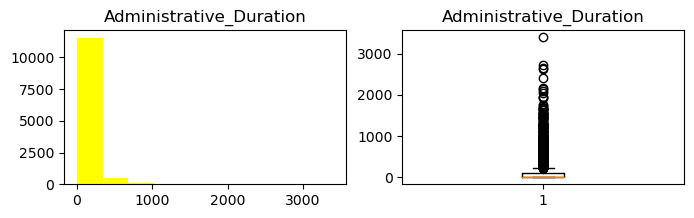

count    12205.000000
mean        81.646331
std        177.491845
min          0.000000
25%          0.000000
50%          9.000000
75%         94.700000
max       3398.750000
Name: Administrative_Duration, dtype: float64


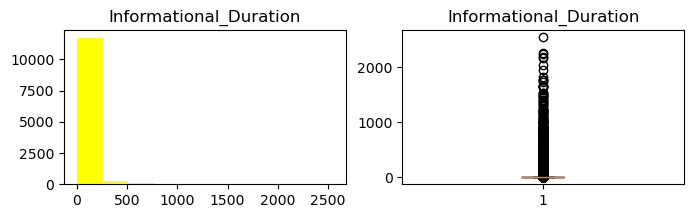

count    12205.000000
mean        34.825454
std        141.424807
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2549.375000
Name: Informational_Duration, dtype: float64


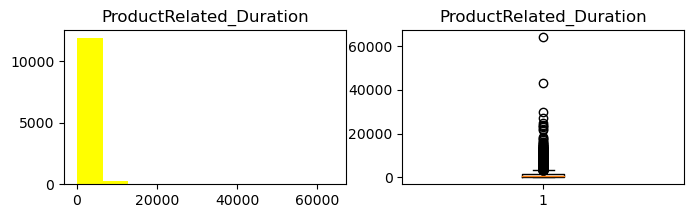

count    12205.000000
mean      1206.982457
std       1919.601400
min          0.000000
25%        193.000000
50%        608.942857
75%       1477.154762
max      63973.522230
Name: ProductRelated_Duration, dtype: float64


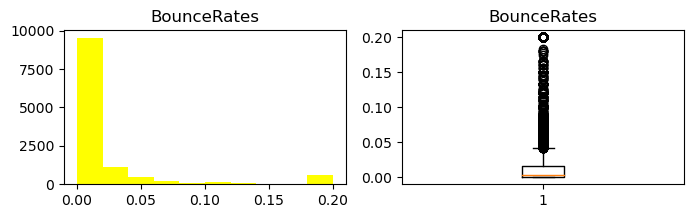

count    12205.000000
mean         0.020370
std          0.045255
min          0.000000
25%          0.000000
50%          0.002899
75%          0.016667
max          0.200000
Name: BounceRates, dtype: float64


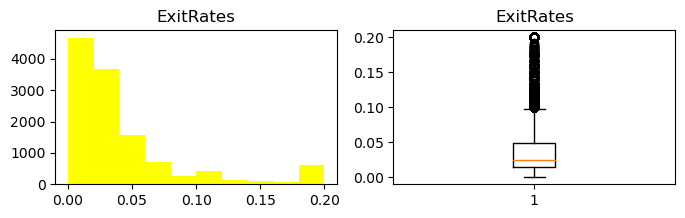

count    12205.000000
mean         0.041466
std          0.046163
min          0.000000
25%          0.014231
50%          0.025000
75%          0.048529
max          0.200000
Name: ExitRates, dtype: float64


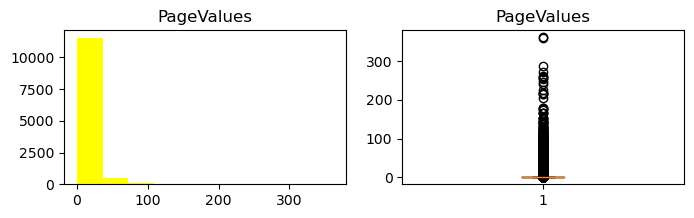

count    12205.000000
mean         5.949574
std         18.653671
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        361.763742
Name: PageValues, dtype: float64


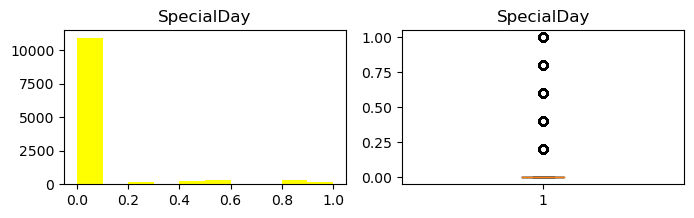

count    12205.000000
mean         0.061942
std          0.199666
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SpecialDay, dtype: float64


In [74]:
univariate(UserCookiesData, categorical_vars, quantitative_vars)

##### Observations from univariate exploration

- Different user types with reference to region are not normally (Gaussian) distributed. This regional data has an exponential distribution. Therefore, we must be concerned with this type distribution.
- Multiple types of traffic are not normally(Gaussian) distributed. This data has an exponential distribution.
- More than 85% of visitors are repeat customers, which is enormous. For marketing purposes, this information can be useful.
- 90% of people only used the top 3 browsers.
- 95% of the users in  this session cookies data uses the top 3 Operating Systems. The online will then need to concentrate on these browsers in order to grow embark on specific operations to increase customer purchases.
- The distribution of Weekend and Revenue statistics is highly unbalanced.

##### Exploring Bivariate Analysis

In [75]:
UserCookiesData.head(1)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0



observed:
 Revenue      0     1    All
Weekend                    
False     7937  1409   9346
True      2360   499   2859
All      10297  1908  12205


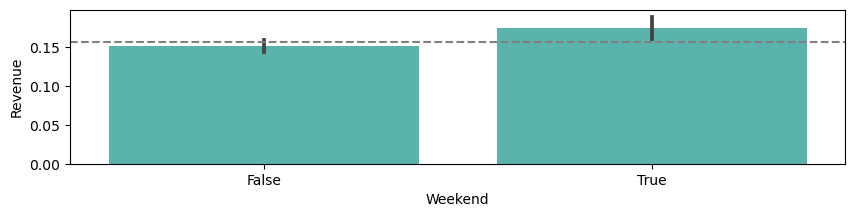

In [76]:
bivariate_categorical(data=UserCookiesData, target="Revenue", categorical_variable ="Weekend" )


observed:
 Revenue               0     1    All
OperatingSystems                    
1                  2170   379   2549
2                  5386  1155   6541
3                  2262   268   2530
4                   393    85    478
5                     5     1      6
6                    17     2     19
7                     6     1      7
8                    58    17     75
All               10297  1908  12205


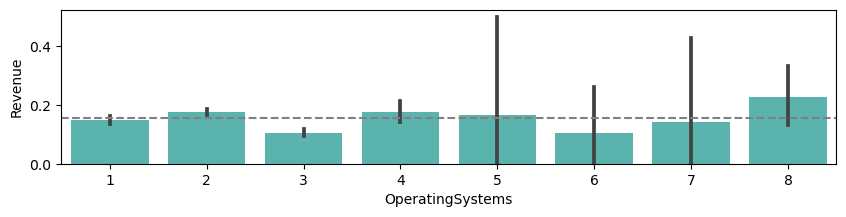

In [77]:
bivariate_categorical(data = UserCookiesData, target= 'Revenue', categorical_variable = 'OperatingSystems')

PageValues 
____________________



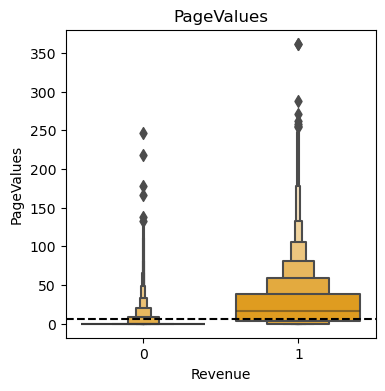

           count       mean        std  min       25%        50%        75%  \
Revenue                                                                       
0        10297.0   1.999985   9.124701  0.0  0.000000   0.000000   0.000000   
1         1908.0  27.264518  35.191954  0.0  3.641144  16.758134  38.897742   

                max  
Revenue              
0        246.758590  
1        361.763742   



In [78]:
bivariate_quant(data = UserCookiesData, target = 'Revenue', quantitative_var = 'PageValues')

ExitRates 
____________________



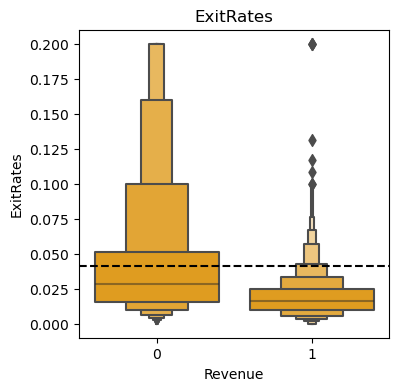

           count      mean       std  min       25%       50%       75%  max
Revenue                                                                     
0        10297.0  0.045526  0.048685  0.0  0.015385  0.028382  0.051538  0.2
1         1908.0  0.019555  0.016463  0.0  0.009521  0.016000  0.025000  0.2 



In [79]:
bivariate_quant(data = UserCookiesData, target = 'Revenue', quantitative_var = 'ExitRates')

BounceRates 
____________________



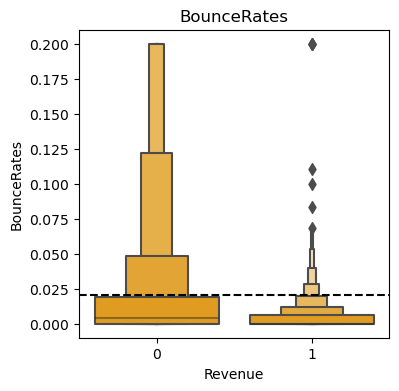

           count      mean       std  min  25%       50%       75%  max
Revenue                                                                
0        10297.0  0.023197  0.048466  0.0  0.0  0.003922  0.019259  0.2
1         1908.0  0.005117  0.012185  0.0  0.0  0.000000  0.006452  0.2 



In [80]:
bivariate_quant(data = UserCookiesData, target="Revenue", quantitative_var="BounceRates")

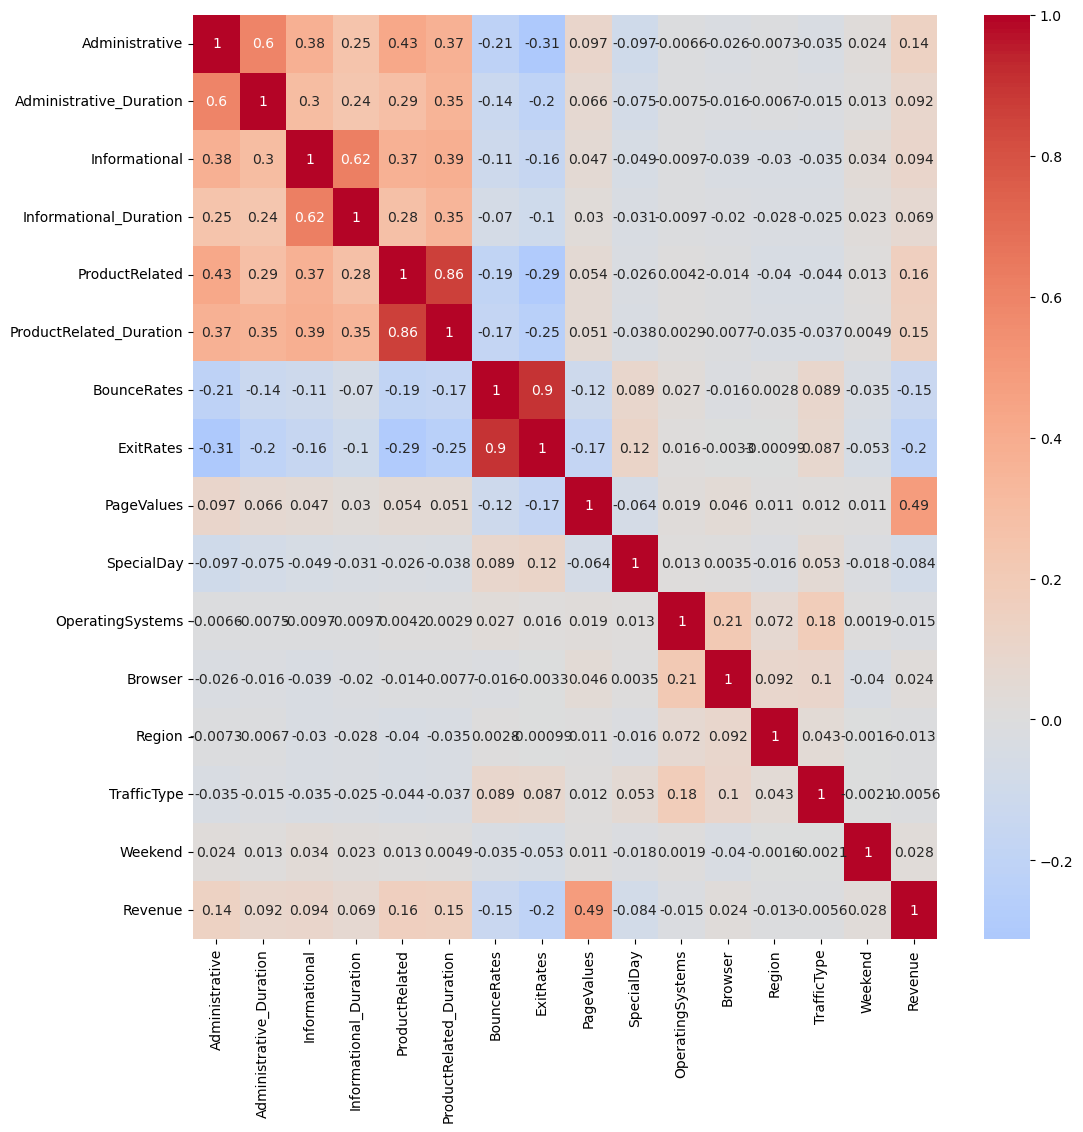

In [81]:
plt.figure(figsize=(12, 12))
sns.heatmap(UserCookiesData.corr(), cmap='coolwarm', center=0, annot=True)
plt.show()

<Figure size 1000x500 with 0 Axes>

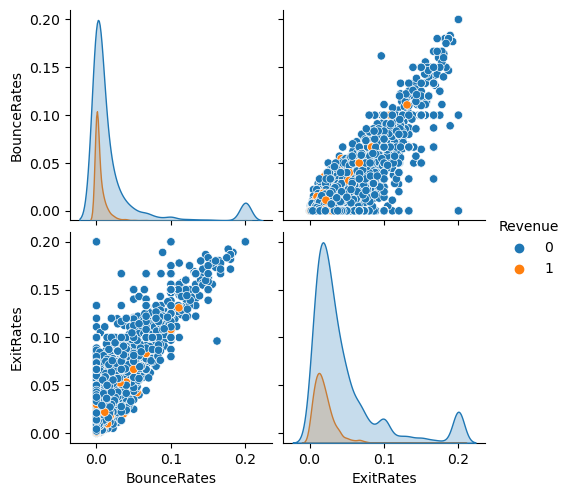

In [82]:
plt.figure(figsize=[10,5])
sns.pairplot(UserCookiesData,x_vars=['BounceRates','ExitRates'],y_vars=['BounceRates','ExitRates'],hue='Revenue',diag_kind='kde')
plt.show()

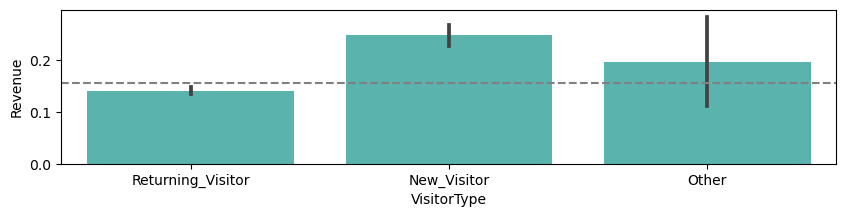

In [83]:

plot_cat_by_target(data =UserCookiesData, target_variable = "Revenue", categorical_var = "VisitorType")

##### *Brief observations from bivariate analysis*

## Statistical Analysis

#### Hypothesis Testing

##### Test Analysis for Categorical variables with label variable (Revenue)

In [84]:
alpha = 0.05

  #### **Hypothesis 1**
  - Ho : Browser type is independent of the revenue(either purchased made or not) of customers 
  - Ha : Browser type is not independent of the revenue(either purchased made or not) of customers


  Using that alpha = 0.05

<AxesSubplot:xlabel='Browser', ylabel='Count'>

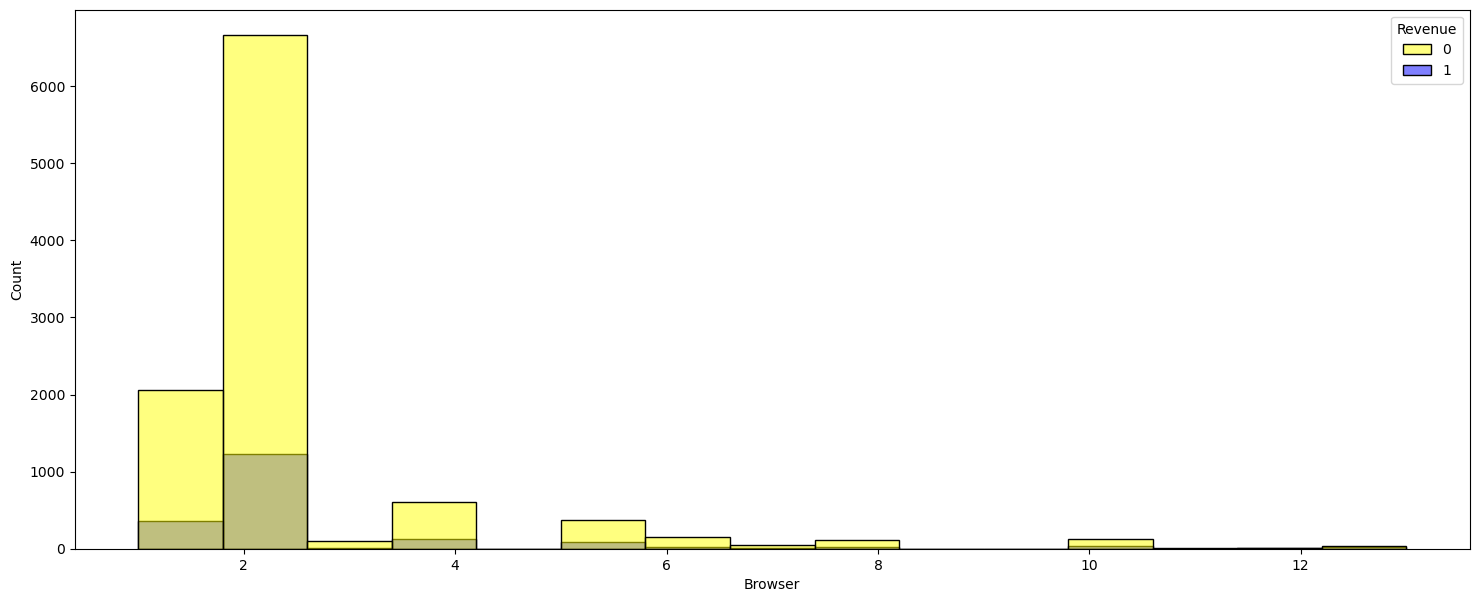

In [85]:
sns.histplot(data=UserCookiesData, x='Browser', hue="Revenue" , palette =["yellow", "blue"] )

In [86]:
test1 = run_chi2(data= UserCookiesData, categorical_var = "Browser", target_variable="Revenue")
test1

(        chi2   p-value  degrees of freedom
 0  29.118987  0.003783                  12,
 Revenue     0     1
 Browser            
 1        2062   365
 2        6660  1223
 3         100     5
 4         601   130
 5         379    86
 6         154    20
 7          43     6
 8         114    21
 9           1     0
 10        131    32
 11          5     1
 12          7     3
 13         40    16,
               0            1
 0   2047.588611   379.411389
 1   6650.655551  1232.344449
 2     88.585416    16.414584
 3    616.723228   114.276772
 4    392.306841    72.693159
 5    146.798689    27.201311
 6     41.339861     7.660139
 7    113.895535    21.104465
 8      0.843671     0.156329
 9    137.518312    25.481688
 10     5.062024     0.937976
 11     8.436706     1.563294
 12    47.245555     8.754445)

In [87]:
test1[0]['p-value']< alpha

0    True
Name: p-value, dtype: bool

* ##### *TakeAways from test 1*
    - Since the p-value is greater than alpha (a significance value of 0.05), we failed to reject the null hypothesis that Browser type is independent of a users decision to make purchase.
    - We conclude that, a user decision to either make purchase from an online shop is not affected by the type of Browser they user
    - This will help us in our next method about feature engineering and feature selection to improve the effectives of some models like the Random forest classifier
    - We will not include Browser type in the features.

#### **Hypothesis 2**

  + Ho : VisitorType is independent of the purchase decision of the user
  + Ha : VisitorType is not independent of the purchase decision of the user

<AxesSubplot:xlabel='VisitorType', ylabel='Count'>

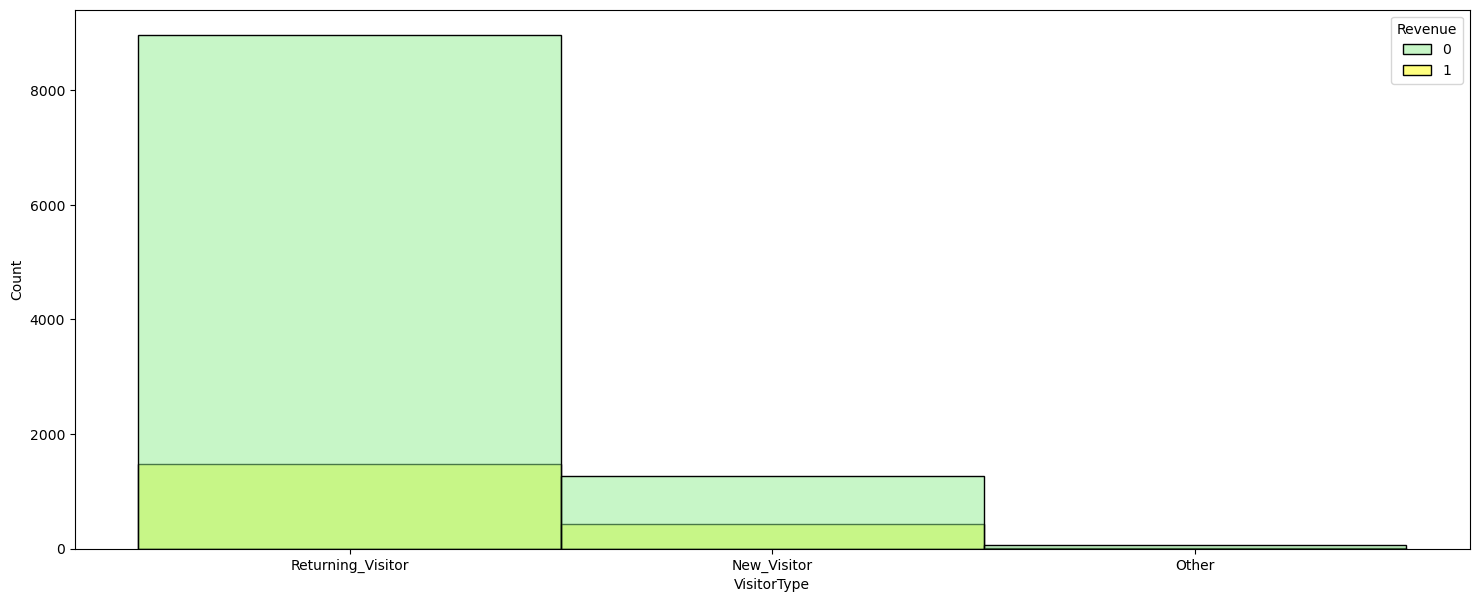

In [88]:
sns.histplot(data=UserCookiesData, x="VisitorType", hue="Revenue", palette=["lightgreen", "yellow"])

In [89]:
test2 = run_chi2(data=UserCookiesData, categorical_var = "VisitorType", target_variable = "Revenue")
test2

(         chi2       p-value  degrees of freedom
 0  130.667627  4.225571e-29                   2,
 Revenue               0     1
 VisitorType                  
 New_Visitor        1271   422
 Other                65    16
 Returning_Visitor  8961  1470,
              0            1
 0  1428.334371   264.665629
 1    68.337321    12.662679
 2  8800.328308  1630.671692)

In [90]:
test2[0]["p-value"] < alpha

0    True
Name: p-value, dtype: bool

* ##### *TakeAways from test 2*
    - Since the p-value is less than alpha (a significance value of 0.05), we reject the null hypothesis that Visitor type is independent of a users decision to make purchase.
    - We conclude that, a user decision to either make purchase from an online shop is not independent of the Visitors Type (Either returning user or new user)
    - This will help us in our next method about feature engineering and feature selection to improve the effectives of some models like the Random forest classifier
    - We will include VisitorType in the features for our Random Forest classifer training

 #### **Hypothesis 3**
   * Ho: ProductRelated is independent of the purchase decision of the user
  * Ha: ProductRelated is independent of the purchase decison of the user

<AxesSubplot:xlabel='ProductRelated', ylabel='Count'>

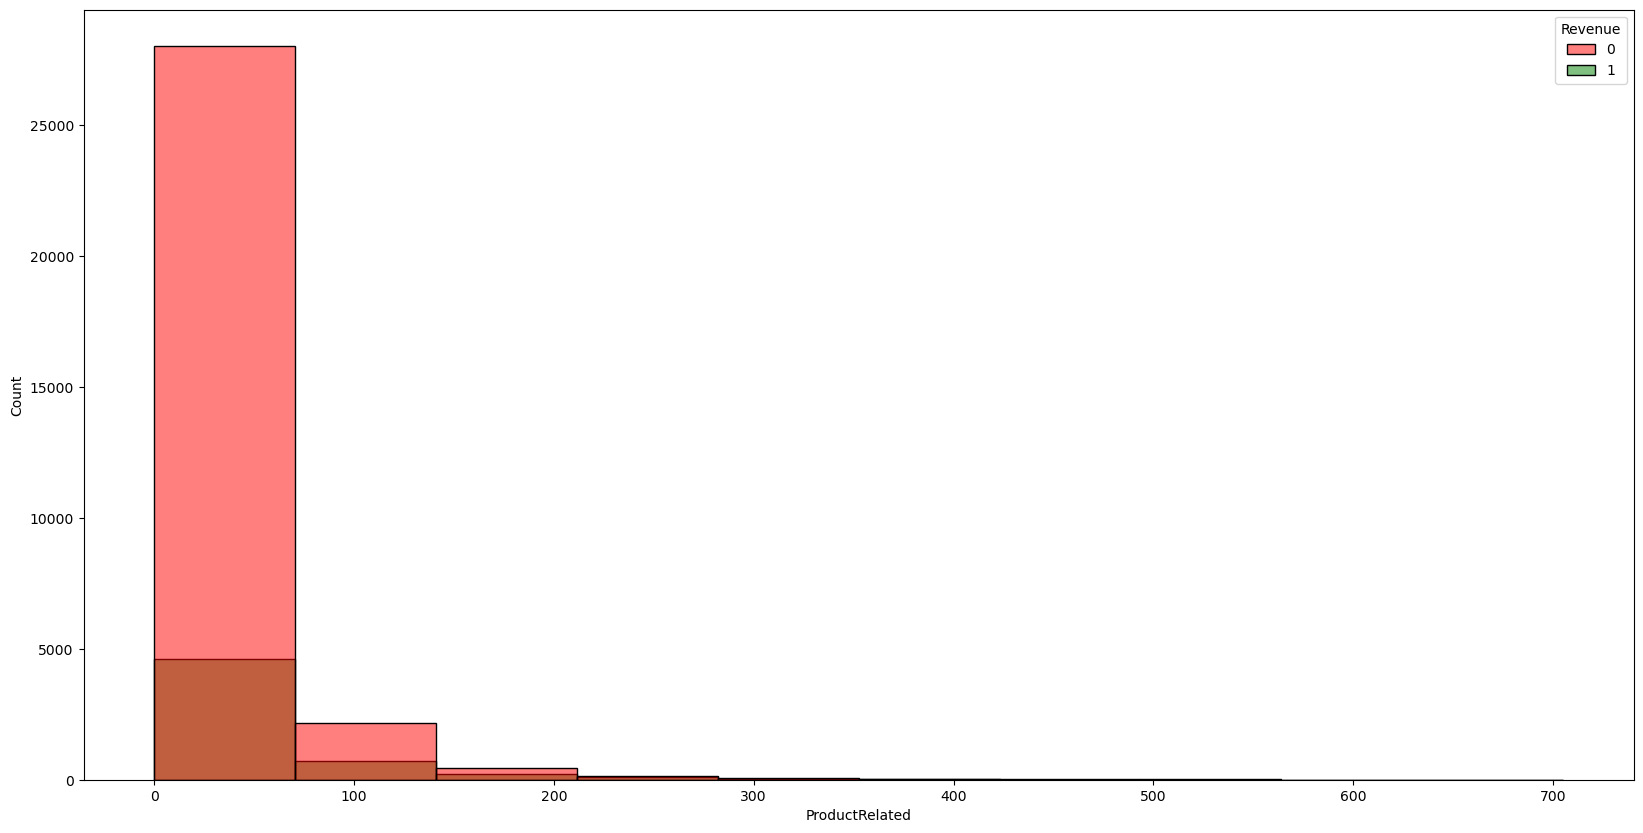

In [91]:
plt.figure(figsize=[20,10])
sns.histplot(data = UserCookiesData,weights=3, x='ProductRelated', hue="Revenue", palette=["red", "green"])

In [92]:
test3 = run_chi2(data=UserCookiesData, categorical_var="ProductRelated", target_variable="Revenue")

* ##### TakeAways from test 3

  #### **Hypothesis 4**
  - Ho:Operating Systems is independent of a users buying decision
  - Ha: Operating Systems is not independent of a users buying decision

<AxesSubplot:xlabel='OperatingSystems', ylabel='Count'>

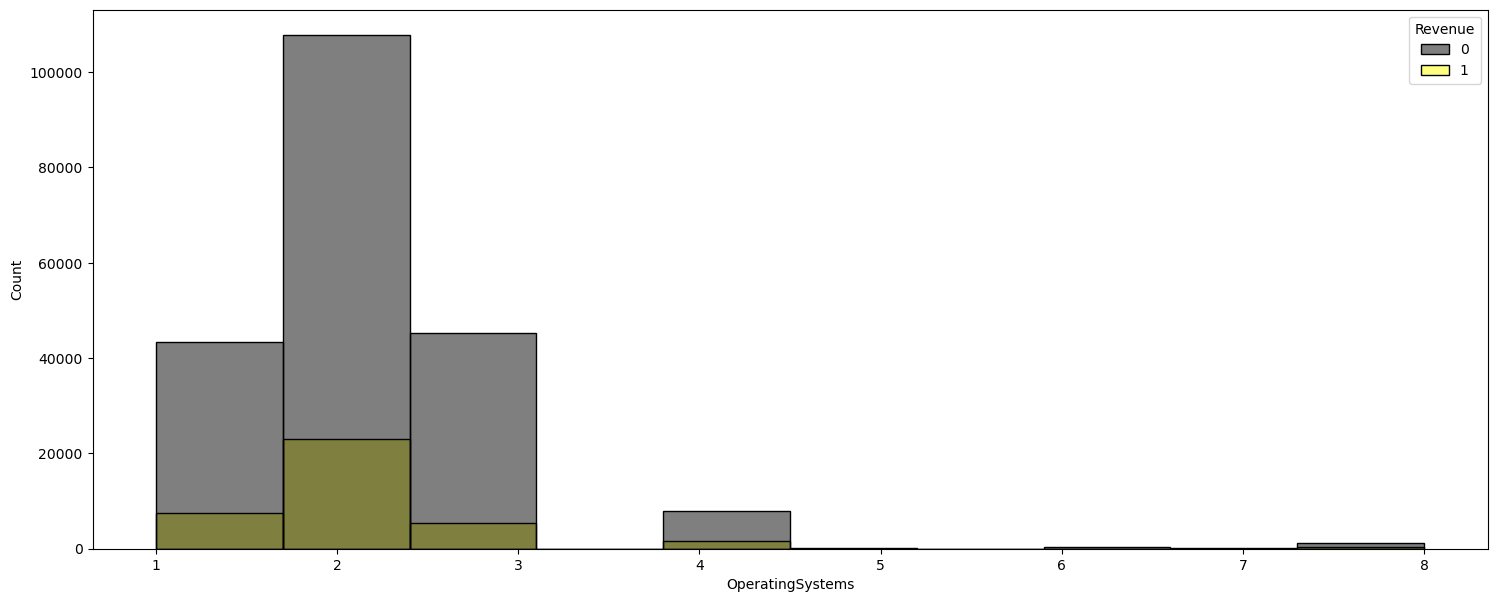

In [93]:
sns.histplot(data = UserCookiesData, weights=20, x = "OperatingSystems", hue = "Revenue", palette=["Black", "Yellow"])

In [94]:
test4 = run_chi2(data=UserCookiesData, categorical_var = "OperatingSystems", target_variable = "Revenue")
test4

(        chi2       p-value  degrees of freedom
 0  75.069931  1.387988e-13                   7,
 Revenue              0     1
 OperatingSystems            
 1                 2170   379
 2                 5386  1155
 3                 2262   268
 4                  393    85
 5                    5     1
 6                   17     2
 7                    6     1
 8                   58    17,
              0            1
 0  2150.516428   398.483572
 1  5518.449570  1022.550430
 2  2134.486686   395.513314
 3   403.274560    74.725440
 4     5.062024     0.937976
 5    16.029742     2.970258
 6     5.905694     1.094306
 7    63.275297    11.724703)

In [95]:
test4[0]['p-value'] < alpha

0    True
Name: p-value, dtype: bool

* ##### *TakeAways from test 4*
    - Since the p-value is less than the significance value of 0.05, we reject the null hypothesis and infer that the Operating Systems type is not independent of the customers intention to make a purchase

 #### **Hypothesis 5**

In [96]:
test5 = run_chi2(data = UserCookiesData, categorical_var = "Weekend", target_variable = "Revenue")
test5

(       chi2   p-value  degrees of freedom
 0  9.204803  0.002414                   1,
 Revenue     0     1
 Weekend            
 False    7937  1409
 True     2360   499,
              0            1
 0  7884.945678  1461.054322
 1  2412.054322   446.945678)

In [97]:
test5[0]['p-value'] < alpha

0    True
Name: p-value, dtype: bool

* ##### *TakeAways from test 5*
    - Since the p-value is greater than alpha (a significance value of 0.05), we failed to reject the null hypothesis that Weekend is independent of a users decision to make purchase.
    - We conclude that, a user decision to either make purchase from an online shop is not affected by the whether the user visits the website on weekends or not
    - This pre-informs us that Weekend as a feature will not be used in our feature engineering and feature selection to improve the effectives of some models like the Random forest classifier
    - We will not include Weekend in the features.

#### **Hypothesis test 6**

  * Ho: The Region location of a customer is independent of the purchasing intent of the customer
* Ha: The Region location of a customer is not independent of the purchasing intent of the customer

<AxesSubplot:xlabel='Region', ylabel='Count'>

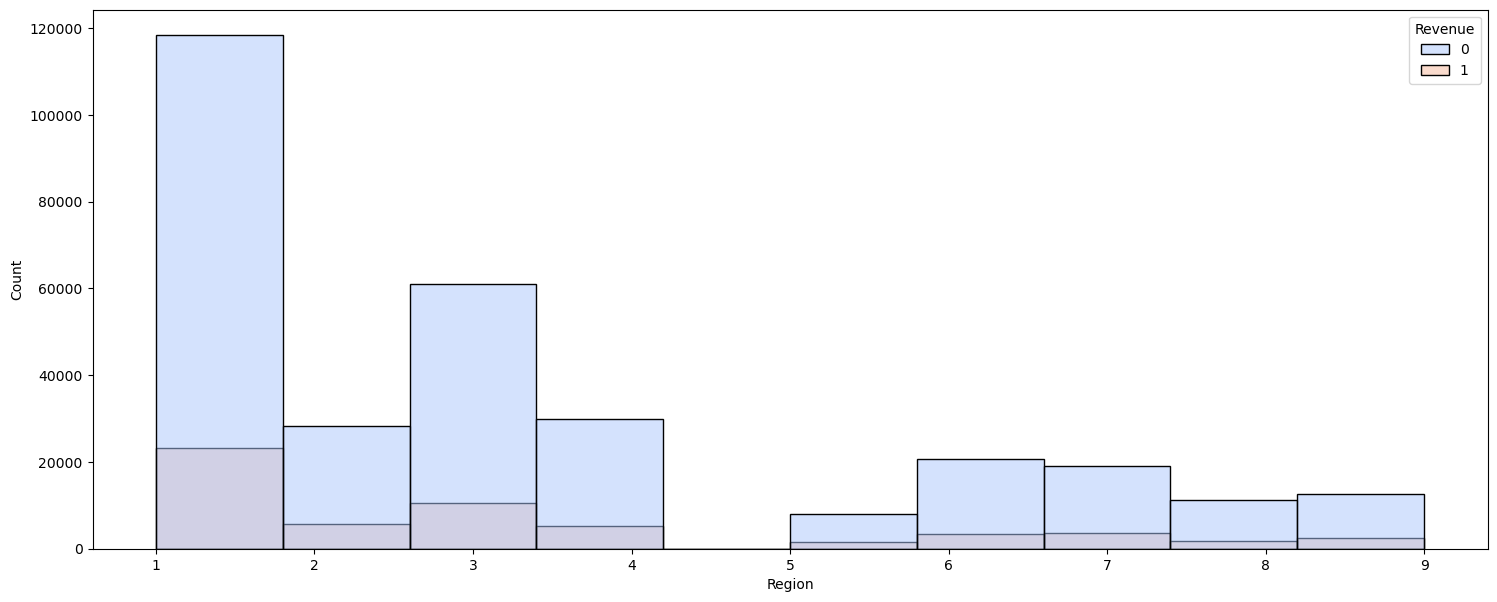

In [98]:

sns.histplot(data=UserCookiesData, x = "Region", hue="Revenue", bins=10, weights=30,palette="coolwarm" )

In [99]:
test6 = run_chi2(data=UserCookiesData, categorical_var="Region", target_variable = "Revenue")
print(test6)

(       chi2   p-value  degrees of freedom
0  9.679351  0.288256                   8, Revenue     0    1
Region            
1        3943  771
2         940  188
3        2030  349
4         996  175
5         266   52
6         689  112
7         639  119
8         375   56
9         419   86,              0           1
0  3977.063335  736.936665
1   951.660467  176.339533
2  2007.092421  371.907579
3   987.938304  183.061696
4   268.287259   49.712741
5   675.780172  125.219828
6   639.502335  118.497665
7   363.622040   67.377960
8   426.053667   78.946333)


In [100]:
test6[0]['p-value'] < alpha

0    False
Name: p-value, dtype: bool

* ##### *TakeAways from test 6*
   - Since the p-value is greater than the significane value of 0.05, we reject the null hypothesis and a conclsion drawn that the purchasing intent of a customer is not dependent on the Region location of a customer.

##### **Hypothesis Test Analysis for Quantitative variables with label variable (Revenue)**

In [101]:
quant_vars = ['BounceRates', 'ExitRates', 'PageValues', 'Administrative_Duration','Informational_Duration','ProductRelated_Duration']

In [102]:
two_t_test(data = UserCookiesData, quantitative_vars=quant_vars, target_variable = 'Revenue')

,Feature,P-Value,Significance
0,BounceRates,0.0,significant
1,ExitRates,0.0,significant
2,PageValues,0.0,significant
3,Administrative_Duration,0.0,significant
4,Informational_Duration,0.0,significant
5,ProductRelated_Duration,0.0,significant


* ##### ***TakeAways from the levene, mannwhitneyu and shiporo-wilk test for the numerical variables***

## DATA PREPROCESSING

##### *Encoding both weekend and the label variable (Revenue) into numeric for modelling*

In [103]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [104]:
UserCookiesEncoded = pd.get_dummies(UserCookiesData)

In [105]:
UserCookiesEncoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [106]:
UserCookiesEncoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12205 entries, 0 to 12329
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12205 non-null  int64  
 1   Administrative_Duration        12205 non-null  float64
 2   Informational                  12205 non-null  int64  
 3   Informational_Duration         12205 non-null  float64
 4   ProductRelated                 12205 non-null  int64  
 5   ProductRelated_Duration        12205 non-null  float64
 6   BounceRates                    12205 non-null  float64
 7   ExitRates                      12205 non-null  float64
 8   PageValues                     12205 non-null  float64
 9   SpecialDay                     12205 non-null  float64
 10  OperatingSystems               12205 non-null  int64  
 11  Browser                        12205 non-null  int64  
 12  Region                         12205 non-null 

In [107]:
encoder = LabelEncoder()

In [108]:
UserCookiesEncoded["Weekend"] = encoder.fit_transform(UserCookiesEncoded["Weekend"])

In [109]:
UserCookiesEncoded["Revenue"] = encoder.fit_transform(UserCookiesEncoded["Revenue"])

In [110]:
UserCookiesEncoded["Revenue"].value_counts()

0    10297
1     1908
Name: Revenue, dtype: int64

##### *Data segmentation into training and testing data sets*

In [111]:
y_label = UserCookiesEncoded["Revenue"]
x_label = UserCookiesEncoded.drop(["Revenue"],axis=1)

In [112]:
x_label

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,...,0,0,0,0,0,0,0,0,0,1
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,1
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,1
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,1


In [113]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
x_label=pd.DataFrame(ss.fit_transform(x_label))
x_label

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.702302,-0.460019,-0.398824,-0.246257,-0.696218,-0.628793,3.969402,3.434394,-0.318962,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,-0.568614,-0.217026,-0.195205,-0.401315,-0.081737,0.412395
1,-0.702302,-0.460019,-0.398824,-0.246257,-0.673793,-0.595451,-0.450137,1.268054,-0.318962,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,-0.568614,-0.217026,-0.195205,-0.401315,-0.081737,0.412395
2,-0.702302,-0.460019,-0.398824,-0.246257,-0.696218,-0.628793,3.969402,3.434394,-0.318962,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,-0.568614,-0.217026,-0.195205,-0.401315,-0.081737,0.412395
3,-0.702302,-0.460019,-0.398824,-0.246257,-0.673793,-0.627404,0.654748,2.134590,-0.318962,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,-0.568614,-0.217026,-0.195205,-0.401315,-0.081737,0.412395
4,-0.702302,-0.460019,-0.398824,-0.246257,-0.494387,-0.301889,-0.008183,0.184884,-0.318962,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,-0.568614,-0.217026,-0.195205,-0.401315,-0.081737,0.412395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12200,0.198517,0.356953,-0.398824,-0.246257,0.469915,0.300496,-0.292296,-0.269384,0.337328,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,-0.568614,-0.217026,-0.195205,-0.401315,-0.081737,0.412395
12201,-0.702302,-0.460019,-0.398824,-0.246257,-0.606516,-0.386155,-0.450137,-0.436133,-0.318962,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,1.758662,-0.217026,-0.195205,-0.401315,-0.081737,0.412395
12202,-0.702302,-0.460019,-0.398824,-0.246257,-0.584090,-0.532806,1.391338,0.979209,-0.318962,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,1.758662,-0.217026,-0.195205,-0.401315,-0.081737,0.412395
12203,0.498791,-0.037447,-0.398824,-0.246257,-0.382259,-0.448540,-0.450137,-0.442214,-0.318962,-0.31024,...,-0.191557,-0.154627,-0.424025,-0.612418,1.758662,-0.217026,-0.195205,-0.401315,-0.081737,0.412395


In [114]:

x_train, x_test, y_train, y_test = train_test_split(x_label, y_label, test_size =  0.2, random_state = 0)

In [115]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9764 entries, 1946 to 2732
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9764 non-null   float64
 1   1       9764 non-null   float64
 2   2       9764 non-null   float64
 3   3       9764 non-null   float64
 4   4       9764 non-null   float64
 5   5       9764 non-null   float64
 6   6       9764 non-null   float64
 7   7       9764 non-null   float64
 8   8       9764 non-null   float64
 9   9       9764 non-null   float64
 10  10      9764 non-null   float64
 11  11      9764 non-null   float64
 12  12      9764 non-null   float64
 13  13      9764 non-null   float64
 14  14      9764 non-null   float64
 15  15      9764 non-null   float64
 16  16      9764 non-null   float64
 17  17      9764 non-null   float64
 18  18      9764 non-null   float64
 19  19      9764 non-null   float64
 20  20      9764 non-null   float64
 21  21      9764 non-null   float64
 2

## MODEL TRAINING AND TESTING

#### ***Random Forest Modelling***

In [116]:
from sklearn.metrics import confusion_matrix

In [117]:


def compare_random_classifier_models(x_train, y_train, x_test, y_test):
    models_cont = []
    for num in range(2, 20):
        for val in range(1, 23):
            classifier = RandomForestClassifier(n_estimators=50, random_state = 126, max_depth = num, min_samples_leaf = val)
            classifier.fit(x_train, y_train)
            train_score = classifier.score(x_train, y_train)
            predictions = classifier.predict(x_test)

            tp = confusion_matrix(y_test, predictions)[1][1]
            fp = confusion_matrix(y_test, predictions)[0][1]
            tn = confusion_matrix(y_test, predictions)[0][0]
            fn = confusion_matrix(y_test, predictions)[1][0]
            test_score = classifier.score(x_test, y_test)
            eval_params = {
                'max_depth':num,
                'min_samples_leaf': val,
                'True Positves': tp,
                'False Positives': fp,
                'True Negatives': tn,
                'False Negatvies': fn,
                'Precision': tp / (tp + fp),
                'Recall': tp / (tp + fn),
                'Specificity': round(tn / (tn + fp),2),
                'Training Accuracy': round(train_score, 2),
                'Test Accuracy': round(test_score,2)
            }
            models_cont.append(eval_params)
    return pd.DataFrame(models_cont)


In [118]:
compare_random_classifier_models(x_train, y_train, x_test, y_test)

,max_depth,min_samples_leaf,True Positves,False Positives,True Negatives,False Negatvies,Precision,Recall,Specificity,Training Accuracy,Test Accuracy
0,2,1,0,0,2063,378,NaN,0.000000,1.00,0.84,0.85
1,2,2,0,0,2063,378,NaN,0.000000,1.00,0.84,0.85
2,2,3,0,0,2063,378,NaN,0.000000,1.00,0.84,0.85
3,2,4,0,0,2063,378,NaN,0.000000,1.00,0.84,0.85
4,2,5,0,0,2063,378,NaN,0.000000,1.00,0.84,0.85
...,...,...,...,...,...,...,...,...,...,...,...
391,19,18,188,59,2004,190,0.761134,0.497354,0.97,0.92,0.90
392,19,19,194,67,1996,184,0.743295,0.513228,0.97,0.92,0.90
393,19,20,193,60,2003,185,0.762846,0.510582,0.97,0.92,0.90
394,19,21,189,58,2005,189,0.765182,0.500000,0.97,0.92,0.90


* #### Feature Engineering for random forest model

In [119]:
UserCookiesData_ = UserCookiesData.copy()

In [120]:
UserCookiesData_.drop(['Browser', 'Weekend'], axis=1,inplace=True)

In [121]:

UserCookiesData_["VisitorType"].value_counts()


Returning_Visitor    10431
New_Visitor           1693
Other                   81
Name: VisitorType, dtype: int64

In [122]:
UserCookiesData["Month"]

0        Feb
1        Feb
2        Feb
3        Feb
4        Feb
        ... 
12325    Dec
12326    Nov
12327    Nov
12328    Nov
12329    Nov
Name: Month, Length: 12205, dtype: object

In [123]:
UserCookiesData_["VisitorType"].replace(["Returning_Visitor","New_Visitor", "Other" ], [0,1,2], inplace = True)

In [124]:
UserCookiesData_["Month"].replace(["Jan","Feb", "Mar", "Apr", "May","June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec" ], [0,1,2, 3,4,5,6,7,8,9,10,11], inplace = True)

In [125]:
y_label_ = UserCookiesData_["Revenue"]
x_label_ = UserCookiesData_.drop(["Revenue"],axis=1)

In [126]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(x_label_, y_label_, test_size =  0.2, random_state = 0)

In [127]:
x_train_.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Region,TrafficType,VisitorType
1993,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,3,9,0
7594,5,38.577778,2,9.0,7,584.377778,0.000000,0.064352,0.000000,0.0,6,1,1,2,0
4211,1,4.000000,0,0.0,49,4651.033333,0.020000,0.050000,0.000000,0.8,4,2,7,2,0
850,0,0.000000,1,26.0,15,817.416667,0.026667,0.038222,0.000000,0.0,2,2,6,1,0
2894,7,290.666667,0,0.0,35,1384.533333,0.001754,0.016886,12.685832,0.0,4,2,2,2,0


In [128]:
def test_best_random_forest_classifier(x_train, y_train, x_test, y_test):
    classifier = RandomForestClassifier(random_state = 123, max_depth = 394, min_samples_leaf = 19)
    classifier.fit(x_train, y_train)
    train_score = classifier.score(x_train, y_train)
    test_score = classifier.score(x_test, y_test)
    predictions = classifier.predict(x_test)
    print(predictions)
    tp = confusion_matrix(y_test, predictions)[1][1]
    fp = confusion_matrix(y_test, predictions)[0][1]
    tn = confusion_matrix(y_test, predictions)[0][0]
    fn = confusion_matrix(y_test, predictions)[1][0]
    test_score = classifier.score(x_test, y_test)
    eval_params = {
        'max_depth':395,
        'min_samples_leaf': 19,
        'True Positves': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatvies': fn,
        'Precision': tp / (tp + fp),
        'Recall': tp / (tp + fn),
        'Specificity': round(tn / (tn + fp),3),
        'Training Accuracy': round(train_score, 3),
        'Test Accuracy': round(test_score,3)
    }
    test_results = [eval_params]
    test_df = pd.DataFrame(test_results)
    return classifier, test_df

In [129]:
rf_model = test_best_random_forest_classifier(x_train_, y_train_, x_test_, y_test_)

[0 0 0 ... 0 0 0]


In [130]:
rf_model[1]

,max_depth,min_samples_leaf,True Positves,False Positives,True Negatives,False Negatvies,Precision,Recall,Specificity,Training Accuracy,Test Accuracy
0,395,19,190,63,2000,188,0.750988,0.502646,0.969,0.921,0.897


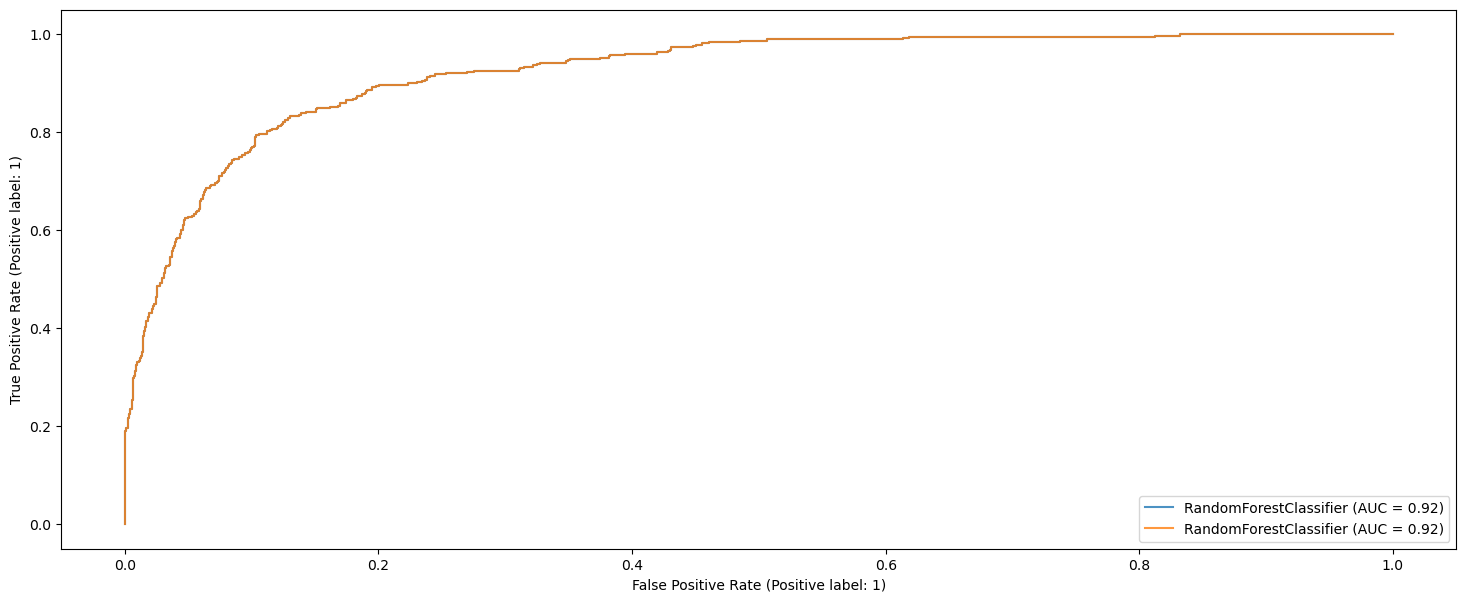

In [131]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf_model[0], x_test_, y_test_, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [132]:
predictions = rf_model[0].predict(x_test_)

<Figure size 200x100 with 0 Axes>

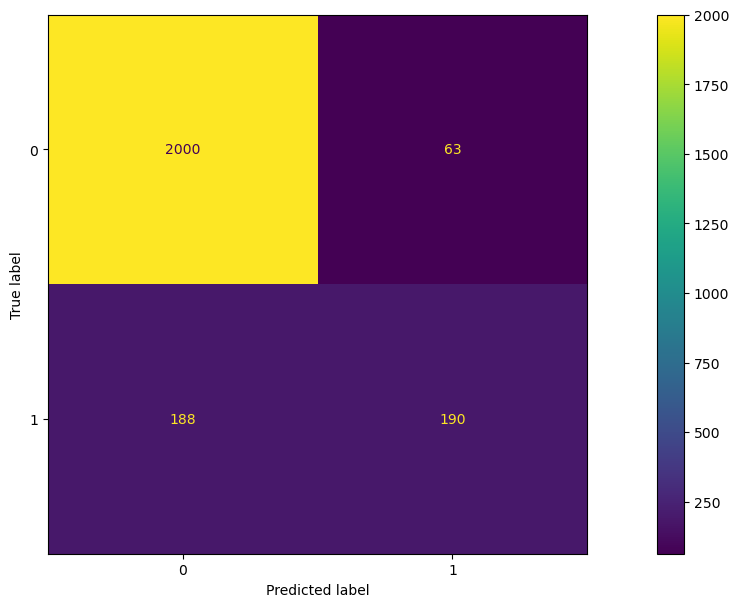

In [133]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm_1 = confusion_matrix(y_test_, predictions, labels=rf_model[0].classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm_1,display_labels=rf_model[0].classes_)
plt.figure(figsize=(2,1))
display.plot()
plt.show()

In [ ]:
with open("model.pkl", "wb") as f:
  pc.dump(rf_model[0], f)  

* #### HyperParameter Tunning for random forest model

In [ ]:
from pprint import pprint
tuned_rf = RandomForestClassifier(random_state = 123)
print('Parameters currently in use:\n')
pprint(tuned_rf.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
rf = RandomForestClassifier()
tuned_rnf= RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
tuned_rnf.fit(x_train, y_train)

In [ ]:
def evaluate(model, x_test, y_test):
    predictions = model.predict(x_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    print('Model Performance')
    print()
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(model.score(x_test, y_test)))

In [ ]:
best_random = tuned_rnf.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)

In [ ]:
intent_rf_pipeline = pc.load(
    open("./model.pkl", "rb")
)

intent_rf_pipeline.predict(x_test_)[1]

#### ***KNN Modelling***

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(x_train, y_train)

In [ ]:
knn_classifier.predict(x_test)

In [ ]:
knn_classifier.score(x_test, y_test)

- * With a random choice for k=3, we had an accuracy of 85%, which is a good start for this model

* ##### K-Fold cross validation for KNN model

In [ ]:
knn_cross_valid = KNeighborsClassifier(n_neighbors=3)
cv_scores = cross_val_score(knn_cross_valid, x_train, y_train, cv=5)
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores, keepdims = True)))

- * With a K-Fold cross validation for the KNN model we had an improvement in accuracy which is 86%

* ##### GridSearchCv hypertuning for KNN model

In [ ]:

knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(x_train, y_train)

In [ ]:
knn_gscv.best_params_

In [ ]:
knn_gscv.best_score_

- * With GridSearchCv hypertuning for the KNN model there was a slight improvement in the models accuracy to 87%

### TRAINING WITH SMOTE FOR BALANCING

In [ ]:
from imblearn.over_sampling import RandomOverSampler
smote=RandomOverSampler(random_state=42)
X_new,Y_new=smote.fit_resample(x_label,y_label)
X_new=pd.DataFrame(X_new,columns=x_train.columns)
Y_new=pd.DataFrame(Y_new,columns=['Revenue'])
X_new.head()

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X_new,Y_new,test_size=0.2,random_state=1)

In [ ]:
rf_with_smote=RandomForestClassifier(n_estimators=50,max_depth=16)
rf_with_smote.fit(x_train,y_train)
print('Train score:',rf_with_smote.score(x_train,y_train))
print('Test score:',rf_with_smote.score(x_test,y_test))